#  <center>  Object Detection Project </center>

---

**Task**
Object Detection

**Dataset**
COCO 2017 (20,000 training images, 5,000 validation images)

**Model Architecture**
- **Backbone**: ResNet-50 (pretrained)
- **Neck**: Feature Pyramid Network (FPN)
- **Head**: YOLO-style Detection Head


In [ ]:
import yaml

from datasets.coco_dataset import COCODataset
from torch.utils.data import DataLoader

import torch
from torch.utils.tensorboard import SummaryWriter #type: ignore

In [ ]:
from datasets.collate import collate_fn
from utils.show_image import display_image
from utils.preprocess import get_normalize_transform

---

# 0. Configs

In [ ]:
with open('configs.yaml', 'r', encoding='utf-8') as f:
    cf = yaml.safe_load(f)

In [ ]:
DIR_TRAIN = cf['data']['images']['train']
DIR_VAL = cf['data']['images']['val']

PATH_ANN_TRAIN = cf['data']['annotations']['train']
PATH_ANN_VAL = cf['data']['annotations']['val']

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 1. Load dataset

In [ ]:
train_dataset = COCODataset(img_dir=DIR_TRAIN, ann_file=PATH_ANN_TRAIN, transform=get_normalize_transform())
print('Load train dataset done')

val_dataset = COCODataset(img_dir=PATH_ANN_TRAIN, ann_file=PATH_ANN_VAL, transform=get_normalize_transform())
print('Load validation dataset done')

loading annotations into memory...
Done (t=2.79s)
creating index...
index created!
Load train dataset done
loading annotations into memory...
Done (t=1.15s)
creating index...
index created!
Load validation dataset done


## 1.1. DataLoader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=2, shuffle=False, collate_fn=collate_fn)

## 1.2. Show image with ground truth

Display image: 1
image shape: torch.Size([3, 640, 640])
boxes shape: torch.Size([30, 4])
labels shape: torch.Size([30])


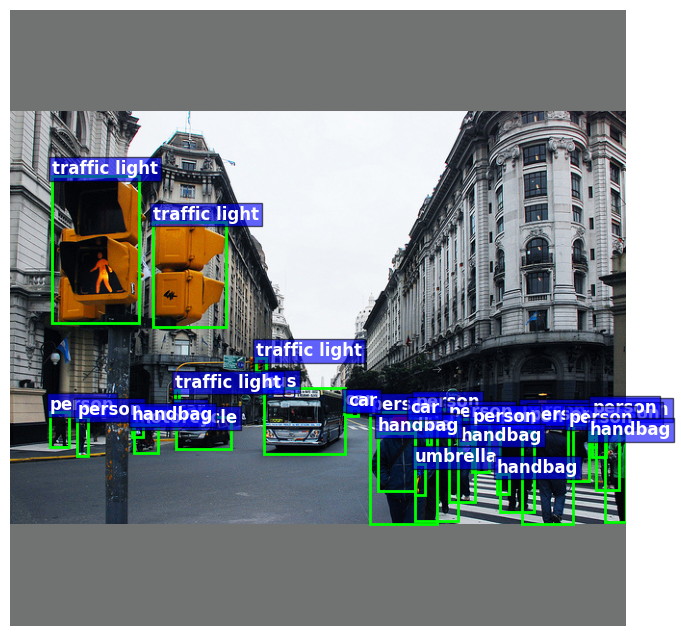

Display image: 2
image shape: torch.Size([3, 640, 640])
boxes shape: torch.Size([2, 4])
labels shape: torch.Size([2])


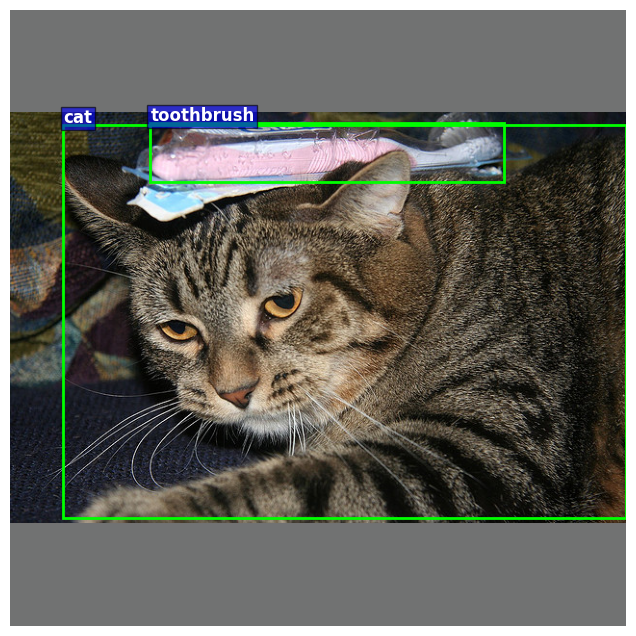

Display image: 3
image shape: torch.Size([3, 640, 640])
boxes shape: torch.Size([22, 4])
labels shape: torch.Size([22])


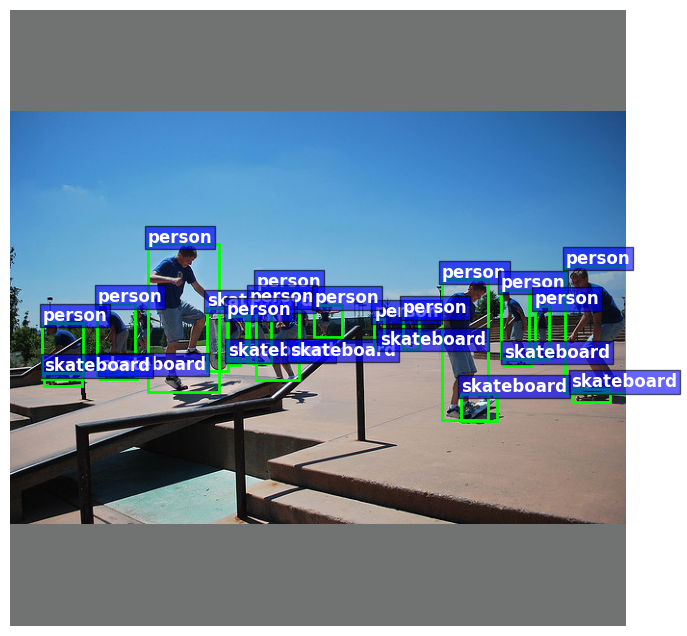

In [ ]:
import random 
random.seed(42)

for i in range(3):
    # random_number = random.randint(0, len(train_dataset)-1)
    img, target = train_dataset[i]

    # image, target shape
    print(f"Display image: {i+1}")
    print(f"image shape: {img.shape}")
    print(f"boxes shape: {target['boxes'].shape}")
    print(f"labels shape: {target['labels'].shape}")

    display_image(img, target=target, israw=True, class_names=cf['data']['labels_categories'])

---

# 2. Models

## Model detection

In [ ]:
from models.yolo_detector import ResNetBackbone, FPN, Detector

resnet50 = ResNetBackbone(pretrained=True)
fpn = FPN()
model = Detector(backbone=resnet50, fpn=fpn)

model = model.to(device)
print(model)

Detector(
  (backbone): ResNetBackbone(
    (stage1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (stage2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

## Loss

In [ ]:
from models.loss import DetectionLoss
criterion = DetectionLoss()

## Optimizer

In [ ]:
from torch import optim 

backbone_params = []
head_params = []
no_decay_params = []

optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5, 'weight_decay': 0.01}, 
    {'params': head_params,     'lr': 3e-4, 'weight_decay': 0.01},
    {'params': no_decay_params, 'lr': 3e-4, 'weight_decay': 0.0}
])

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=50, eta_min=1e-6
)

---

# 3. Trainning loop

In [ ]:
# from train import train_one_epoch
# from utils.checkpoint import save_model
# from val import validate_one_epoch

# NUM_EPOCHS = 30

# # writer = SummaryWriter("logs/my_experiment")
# best_map50 = 0.0

# print(f"Start training for {NUM_EPOCHS} epochs...")

# for epoch in range(1, NUM_EPOCHS + 1):
#     # 1. Training
#     train_metrics = train_one_epoch(
#         model, optimizer, criterion,
#         train_loader, device, epoch
#     )

#     # 2. Validate
#     val_metrics = validate_one_epoch(
#         model, criterion,
#         val_loader, device, epoch
#     )
    
#     # 3. Update lr
#     scheduler.step()
#     current_lr = optimizer.param_groups[0]["lr"]

#     # 4. Write Log Tensorboard
#     log_to_tensorboard(writer, epoch, train_metrics, val_metrics) #type: ignore
    
#     writer.add_scalar("Hyperparameters/Learning_Rate", current_lr, epoch) #type: ignore

#     # 5. Save Model
#     best_map50, is_best = save_model( 
#         model=model,
#         optimizer=optimizer,
#         epoch=epoch,
#         val_metrics=val_metrics,
#         best_metric=best_map50,
#         save_dir="checkpoints",
#         monitor="map_50", 
#         mode="max"
#     )

#     # 6. Hiển thị thông tin sau mỗi epoch
#     print(
#         f"Epoch {epoch}/{NUM_EPOCHS} | LR: {current_lr:.6f} | "
#         f"Train Loss: {train_metrics['total_loss']:.4f} | "
#         f"Val Loss: {val_metrics['total_loss']:.4f} | "
#         f"mAP@50: {val_metrics['map_50']:.4f} | "
#         f"{'BEST' if is_best else ''}"
#     )

# writer.close() #type: ignore
# print("Training Completed!")

---

## Load model

In [ ]:
from utils.checkpoint import load_model

model = load_model(model, cf['best_model'])
# writer = SummaryWriter('runs/logs/architectural_model')

# dump_input = torch.randn(1, 3, 640, 640)
# writer.add_graph(model, dump_input)
# writer.close()

f:\Document\object_detection_coco2017\.venv\lib\site-packages\torch\jit\_trace.py:1065: TracerWarning: Encountering a list at the output of the tracer might cause the trace to be incorrect, this is only valid if the container structure does not change based on the module's inputs. Consider using a constant container instead (e.g. for `list`, use a `tuple` instead. for `dict`, use a `NamedTuple` instead). If you absolutely need this and know the side effects, pass strict=False to trace() to allow this behavior.
  module._c._create_method_from_trace(


In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
from utils.box_ops import decode_outputs
from utils.nms import non_max_suppression
from utils.preprocess import preprocess_image


def detect_and_visualize(
    model,
    image_path,
    device,
    class_names,
    img_size=640,
    conf_thres=0.25,
    iou_thres=0.5,
):
    # 1. Read image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # type: ignore

    # 2. Preprocess
    img_tensor, meta = preprocess_image(img, img_size=img_size)
    img_tensor = img_tensor.unsqueeze(0).to(device)

    # 3. Inference
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)

    # 4. Decode + NMS
    preds = decode_outputs(outputs, conf_thres=conf_thres)
    final_boxes = non_max_suppression(preds, iou_thres=iou_thres)

    boxes = final_boxes[0]

    # 5. Scale boxes về ảnh gốc
    if boxes is not None and boxes.numel() > 0:
        scale = meta["scale"]
        pad_x, pad_y = meta["pad_x"], meta["pad_y"]

        boxes[:, [0, 2]] -= pad_x
        boxes[:, [1, 3]] -= pad_y
        boxes[:, :4] /= scale

    # 6. Visualize
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")

    if boxes is not None and boxes.numel() > 0:
        for x1, y1, x2, y2, score, cls in boxes:
            cls = int(cls)
            label = f"{class_names[cls]}: {score:.2f}"

            plt.gca().add_patch(
                plt.Rectangle( # type: ignore
                    (x1, y1),
                    x2 - x1,
                    y2 - y1,
                    fill=False,
                    edgecolor="lime",
                    linewidth=2,
                )
            )
            plt.text(
                x1,
                y1 - 3,
                label,
                color="lime",
                fontsize=10,
                bbox=dict(facecolor="black", alpha=0.5),
            )

    plt.show()

    return boxes

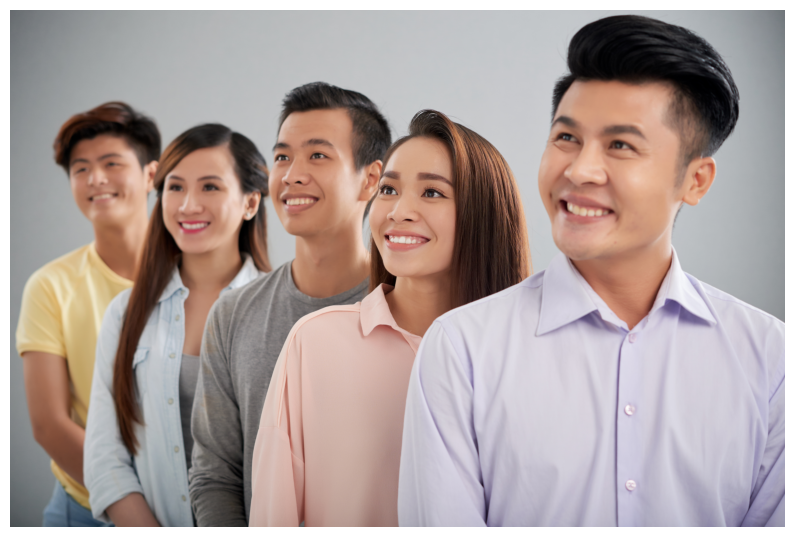

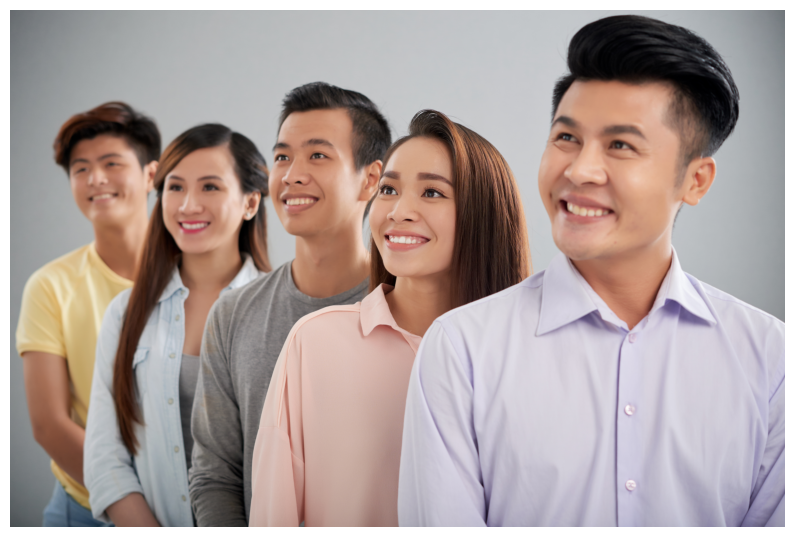

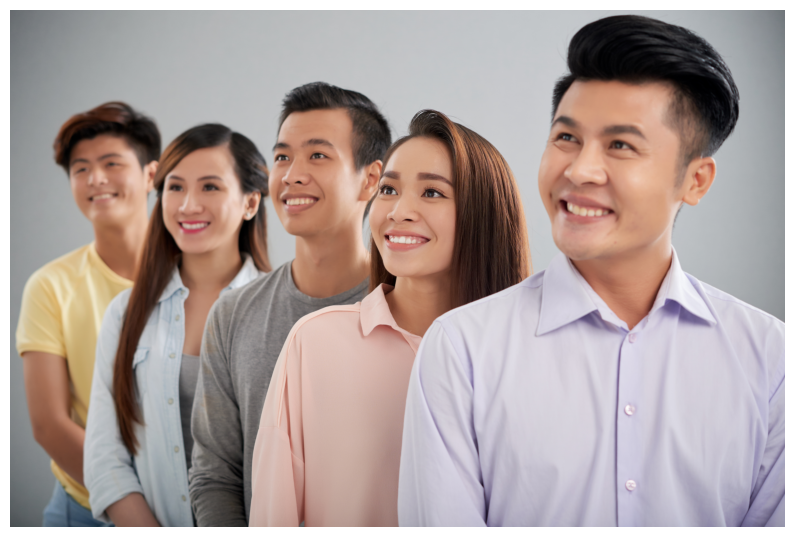

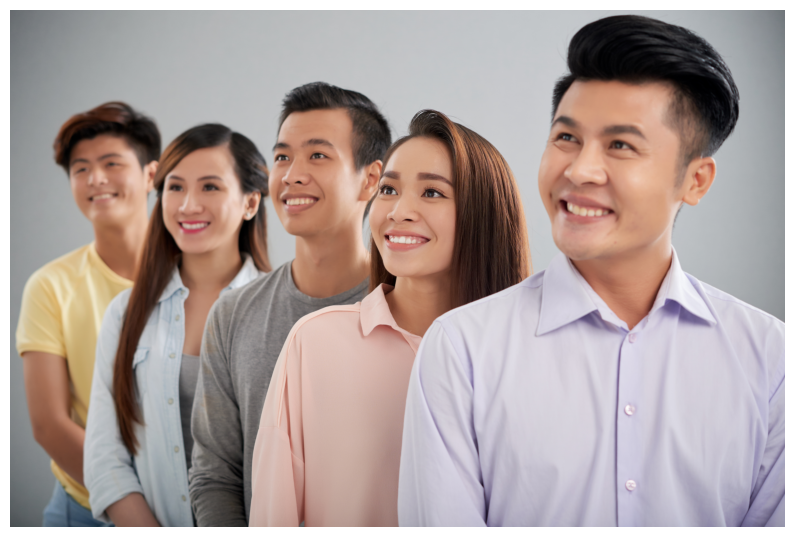

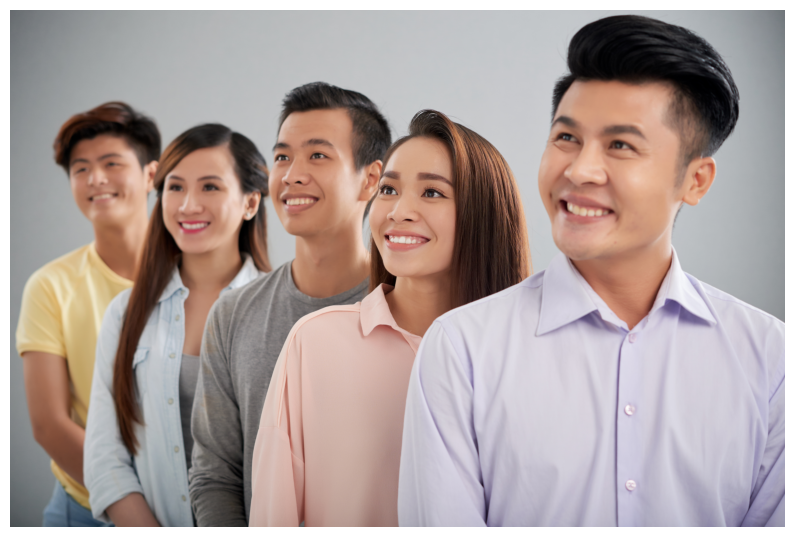

In [ ]:

lst_img = ["data/coco/val2017/000000001503.jpg", "data\\coco\\val2017\\000000581781.jpg", "data\\coco\\val2017\\000000581357.jpg", "data\\coco\\val2017\\000000581100.jpg", 'data/coco/val2017/000000002923.jpg']

for img in lst_img:
    boxes = detect_and_visualize(
    model=model,
    image_path=img,
    device=device,
    class_names=cf["data"]["labels_categories"],
    conf_thres=0.25,
    iou_thres=0.5,
)